In [1]:
from pyspark.sql import SparkSession

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression

import pyspark.sql.functions as f


from itertools import chain
import pandas as pd
import numpy as np
import seaborn as sn 
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [2]:
DB_USER = 'root'
DB_PASS = 'root'
DB_NAME = 'telco_churn'
HOST = 'localhost:3306'

In [3]:
spark = SparkSession.builder.getOrCreate()

In [4]:
spark

# Import Data

In [5]:
status_df = spark.read.format("jdbc").options(
    url=f"jdbc:mysql://{HOST}/{DB_NAME}",
    driver = "com.mysql.jdbc.Driver",
    dbtable = "status",
    user=DB_USER,
    password=DB_PASS, 
    useSSL=False).load()


In [6]:
status_df.printSchema()

root
 |-- Customer ID: string (nullable = true)
 |-- Count: integer (nullable = true)
 |-- Quarter: string (nullable = true)
 |-- Satisfaction Score: integer (nullable = true)
 |-- Customer Status: string (nullable = true)
 |-- Churn Label: string (nullable = true)
 |-- Churn Value: integer (nullable = true)
 |-- Churn Score: integer (nullable = true)
 |-- CLTV: integer (nullable = true)
 |-- Churn Category: string (nullable = true)
 |-- Churn Reason: string (nullable = true)



In [7]:
demographic_df = spark.read.format("jdbc").options(
    url=f"jdbc:mysql://{HOST}/{DB_NAME}",
    driver = "com.mysql.jdbc.Driver",
    dbtable = "demographics",
    user=DB_USER,
    password=DB_PASS, 
    useSSL=False).load()


In [8]:
demographic_df.printSchema()

root
 |-- Customer ID: string (nullable = true)
 |-- Count: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Under 30: string (nullable = true)
 |-- Senior Citizen: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Number of Dependents: integer (nullable = true)



In [9]:
service_df = spark.read.format("jdbc").options(
    url=f"jdbc:mysql://{HOST}/{DB_NAME}",
    driver = "com.mysql.jdbc.Driver",
    dbtable = "services",
    user=DB_USER,
    password=DB_PASS, 
    useSSL=False).load()


In [10]:
service_df.printSchema()

root
 |-- Customer ID: string (nullable = true)
 |-- Count: integer (nullable = true)
 |-- Quarter: string (nullable = true)
 |-- Referred a Friend: string (nullable = true)
 |-- Number of Referrals: integer (nullable = true)
 |-- Tenure in Months: integer (nullable = true)
 |-- Offer: string (nullable = true)
 |-- Phone Service: string (nullable = true)
 |-- Avg Monthly Long Distance Charges: double (nullable = true)
 |-- Multiple Lines: string (nullable = true)
 |-- Internet Service: string (nullable = true)
 |-- Internet Type: string (nullable = true)
 |-- Avg Monthly GB Download: integer (nullable = true)
 |-- Online Security: string (nullable = true)
 |-- Online Backup: string (nullable = true)
 |-- Device Protection Plan: string (nullable = true)
 |-- Premium Tech Support: string (nullable = true)
 |-- Streaming TV: string (nullable = true)
 |-- Streaming Movies: string (nullable = true)
 |-- Streaming Music: string (nullable = true)
 |-- Unlimited Data: string (nullable = true)


In [11]:
df = status_df.join(demographic_df, "Customer ID").join(service_df, "Customer ID")

In [12]:
df = df.filter(df['age'] <= 34)

In [13]:
print(f"Number of columns: {len(df.columns)}")
df.printSchema()

Number of columns: 48
root
 |-- Customer ID: string (nullable = true)
 |-- Count: integer (nullable = true)
 |-- Quarter: string (nullable = true)
 |-- Satisfaction Score: integer (nullable = true)
 |-- Customer Status: string (nullable = true)
 |-- Churn Label: string (nullable = true)
 |-- Churn Value: integer (nullable = true)
 |-- Churn Score: integer (nullable = true)
 |-- CLTV: integer (nullable = true)
 |-- Churn Category: string (nullable = true)
 |-- Churn Reason: string (nullable = true)
 |-- Count: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Under 30: string (nullable = true)
 |-- Senior Citizen: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Number of Dependents: integer (nullable = true)
 |-- Count: integer (nullable = true)
 |-- Quarter: string (nullable = true)
 |-- Referred a Friend: string (nullable = true)
 |-- Number of Referrals: integer (null

# Utils

In [14]:
# remove duplicate columns
def remove_duplicate_columns(df):
    print(f"Initial Number of Columns: {len(df.columns)}")
    df_cols = df.columns
    existed = []
    duplicate_col_index = []
    idx = 0
    for c in df_cols:
        if c in existed:
            duplicate_col_index.append(idx)
        else:
            existed.append(c)
        idx = idx + 1

    for i in duplicate_col_index:
        df_cols[i] = df_cols[i] + '_duplicated'

    df = df.toDF(*df_cols)
    cols_to_remove = [c for c in df_cols if '_duplicated' in c]
    df = df.drop(*cols_to_remove)

    print("\nDuplicated columns removed from the dataframe:")
    print([df_cols[i] for i in duplicate_col_index])
    print(f"\nFinal Number of Columns: {len(df.columns)}")
    return df

In [15]:
def features_selection(df):
    print(f"Initial Number of Columns: {len(df.columns)}")
    
    # Drop columns not used in the model training
    to_drop = [  
        'Customer ID',
        'Quarter',
        'Customer Status',
        'Churn Value',
        'Churn Score',
        'Churn Category',
        'Churn Reason',
        'Age',
        'Number of Dependents',
        'Number of Referrals',
        'Phone Service',
        'Internet Service',
        'Total Charges',
        'Total Refunds',
        'Total Extra Data Charges',
        'Total Long Distance Charges',
        'Total Revenue',
        'Under 30', 
        'Senior Citizen',
        'Streaming Movies',
        'Streaming Music',
        'Streaming TV'
    ]
    df = df.drop(*to_drop)
    
    print("\nUnused columns removed from the dataframe:")
    print(to_drop)
    print(f"\nFinal Number of Columns: {len(df.columns)}")
    return df

In [16]:
def get_columns_by_types(df):
    label_col = 'Churn Label'
    numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' or t[1] == 'double']
    categorical_features = [t[0] for t in df.dtypes if t[1] != 'int' and t[1] != 'double' and t[0] != label_col]

    print(f"Target column: {label_col}")
    print(f"\nTotal {len(numeric_features)} of numeric features")
    print(numeric_features)
    print(f"\nTotal {len(categorical_features)} of categorical features")
    print(categorical_features)
    
    return label_col, numeric_features, categorical_features

In [17]:
def preprocess_data(df, label_col, numeric_features, categorical_features):

    stages = []

    for categoricalCol in categorical_features:
        stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + ' Index')
        encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + " OHE"])
        stages += [stringIndexer, encoder]

    label_string_idx = StringIndexer(inputCol = label_col, outputCol = 'label')
    stages.append(label_string_idx)

    assemblerInputs = [c + " OHE" for c in categorical_features] + numeric_features
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features_vec")
    stages.append(assembler)
    
    scalers = MinMaxScaler(inputCol="features_vec", outputCol="features")
    stages.append(scalers)
    
    print(f"Number of stages: {len(stages)}")
    pipeline = Pipeline(stages = stages)
    pipelineModel = pipeline.fit(df)
    preprocessed_df = pipelineModel.transform(df)
    return preprocessed_df, pipelineModel

In [18]:
def split_train_test(df):
    train, test = df.randomSplit([0.8, 0.2], seed = 2021)
    print("Training Dataset Count: " + str(train.count()))
    print("Test Dataset Count: " + str(test.count()))
    return train, test

In [19]:
def train_model(train):
    lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
    model = lr.fit(train)
    return model

In [20]:
def get_feature_importance_df(df, lrModel):
    attrs = sorted(
        (attr["idx"], attr["name"]) for attr in (chain(*df
            .schema['features_vec']
            .metadata["ml_attr"]["attrs"].values())))
    temp = [(name, lrModel.coefficients[idx]) for idx, name in attrs]
    feature_importance = []
    for d in temp:
        feature_importance.append([d[0].replace('OHE_', ''), float(d[1])])

    # giving column names of dataframe
    columns = ["feature", "importance"]

    # creating a dataframe
    feature_importance_df = spark.createDataFrame(feature_importance, columns)
    feature_importance_df.show()
    return feature_importance_df

In [21]:
def make_predictions_based_on_modifications(df, pipelineModel, model, solution=None):
    if solution is None:
        return None
    
    if solution == 1:
        modified_df = df.withColumn("Online Security", f.when(df["Online Security"]=="No", "Yes").otherwise(df["Online Security"]))
        modified_df = pipelineModel.transform(modified_df)
        solution_description = "Online Security Subscription"
    elif solution == 2:
        modified_df = df.withColumn("Monthly Charge", f.col("Monthly Charge")*0.9)
        modified_df = pipelineModel.transform(modified_df)
        solution_description = "Monthly Charge Discount"
        
    selectedCols = ['label', 'features']
    modified_df = modified_df.select(selectedCols)
    predictions = model.transform(modified_df)
    predictions_modified = predictions.groupBy('prediction').count().orderBy('count', ascending=False).withColumn("prediction", f.when(predictions["prediction"] == 0, "No Churn").otherwise("Churn"))
    predictions_modified = predictions_modified.withColumn('solution', f.lit(solution_description))
    predictions_modified.show()
    return predictions_modified

In [22]:
def insert_to_mysql(feature_importance_df, predictions_modified, host, db_name, db_user, db_pass, driver):

    feature_importance_df.write.format('jdbc').options(
          url=f"jdbc:mysql://{host}/{db_name}",
          driver=driver,
          dbtable='feature_importance',
          user=db_user,
          password=db_pass, 
          useSSL=False).mode('overwrite').save()
    
    predictions_modified.write.format('jdbc').options(
      url=f"jdbc:mysql://{host}/{db_name}",
      driver=driver,
      dbtable='prediction_modified',
      user=db_user,
      password=db_pass, 
      useSSL=False).mode('overwrite').save()
    
    return True

# Data Exploration

In [23]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

21/12/20 18:28:05 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,0,1,2,3,4
Customer ID,0953-LGOVU,1450-SKCVI,2712-SYWAY,3195-TQDZX,3623-FQBOX
Count,1,1,1,1,1
Quarter,Q3,Q3,Q3,Q3,Q3
Satisfaction Score,4,3,3,5,5
Customer Status,Stayed,Churned,Joined,Joined,Stayed
Churn Label,No,Yes,No,No,No
Churn Value,0,1,0,0,0
Churn Score,75,72,54,42,36
CLTV,2562,5276,5249,4050,3632
Churn Category,None,Attitude,None,None,None


In [24]:
df = remove_duplicate_columns(df)

Initial Number of Columns: 48

Duplicated columns removed from the dataframe:
['Count_duplicated', 'Count_duplicated', 'Quarter_duplicated']

Final Number of Columns: 45


In [25]:
df = features_selection(df)

Initial Number of Columns: 45

Unused columns removed from the dataframe:
['Customer ID', 'Quarter', 'Customer Status', 'Churn Value', 'Churn Score', 'Churn Category', 'Churn Reason', 'Age', 'Number of Dependents', 'Number of Referrals', 'Phone Service', 'Internet Service', 'Total Charges', 'Total Refunds', 'Total Extra Data Charges', 'Total Long Distance Charges', 'Total Revenue', 'Under 30', 'Senior Citizen', 'Streaming Movies', 'Streaming Music', 'Streaming TV']

Final Number of Columns: 23


In [26]:
# Check missing values
data_agg = df.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in df.columns])
pd.DataFrame(data_agg.take(5), columns=data_agg.columns).transpose()

,0
Count,0
Satisfaction Score,0
Churn Label,0
CLTV,0
Gender,0
Married,0
Dependents,0
Referred a Friend,0
Tenure in Months,0
Offer,0


In [27]:
label_col, numeric_features, categorical_features = get_columns_by_types(df)

Target column: Churn Label

Total 7 of numeric features
['Count', 'Satisfaction Score', 'CLTV', 'Tenure in Months', 'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download', 'Monthly Charge']

Total 15 of categorical features
['Gender', 'Married', 'Dependents', 'Referred a Friend', 'Offer', 'Multiple Lines', 'Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Unlimited Data', 'Contract', 'Paperless Billing', 'Payment Method']


In [28]:
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Count,2027,1.0,0.0,1,1
Satisfaction Score,2027,3.3339911198815986,1.1732641947158569,1,5
CLTV,2027,4388.640848544647,1146.069510574718,2003,6499
Tenure in Months,2027,31.695609274790332,24.71399273252083,1,72
Avg Monthly Long Distance Charges,2027,23.27655648741985,15.548180703245988,0.0,49.98
Avg Monthly GB Download,2027,35.386778490379875,27.30592259054798,0,85
Monthly Charge,2027,62.21827824371002,30.3431280472131,18.55,118.75


In [29]:
for col in categorical_features:
    print(df.groupBy(col).count().orderBy('count', ascending=False).toPandas())
    print("\n")
    
print(df.groupBy(label_col).count().orderBy('count', ascending=False).toPandas())
print("\n")

   Gender  count
0    Male   1019
1  Female   1008


  Married  count
0      No   1032
1     Yes    995


  Dependents  count
0         No   1489
1        Yes    538


  Referred a Friend  count
0                No   1089
1               Yes    938


     Offer  count
0     None   1066
1  Offer E    251
2  Offer B    241
3  Offer D    176
4  Offer A    165
5  Offer C    128


  Multiple Lines  count
0             No   1238
1            Yes    789


  Internet Type  count
0   Fiber Optic    762
1           DSL    501
2          None    492
3         Cable    272


  Online Security  count
0              No   1410
1             Yes    617


  Online Backup  count
0            No   1343
1           Yes    684


  Device Protection Plan  count
0                     No   1343
1                    Yes    684


  Premium Tech Support  count
0                   No   1399
1                  Yes    628


  Unlimited Data  count
0            Yes   1319
1             No    708


         Contract 

# Data Preprocessing

In [30]:
preprocessed_df, pipelineModel = preprocess_data(df, label_col, numeric_features, categorical_features)

Number of stages: 33


In [31]:
pd.DataFrame(preprocessed_df.take(5), columns=preprocessed_df.columns).transpose()

,0,1,2,3,4
Count,1,1,1,1,1
Satisfaction Score,4,3,3,5,5
Churn Label,No,Yes,No,No,No
CLTV,2562,5276,5249,4050,3632
Gender,Male,Female,Female,Male,Male
Married,Yes,No,No,No,No
Dependents,Yes,No,No,No,No
Referred a Friend,Yes,No,No,No,No
Tenure in Months,12,56,1,3,21
Offer,Offer D,None,Offer E,None,Offer D


In [32]:
train, test = split_train_test(preprocessed_df)

Training Dataset Count: 1630
Test Dataset Count: 397


# Data Modelling

In [33]:
model = train_model(train)

In [34]:
feature_importance_df = get_feature_importance_df(preprocessed_df, model)

+--------------------+--------------------+
|             feature|          importance|
+--------------------+--------------------+
|         Gender Male| -0.2104412134519658|
|          Married No|-0.44885902040276365|
|       Dependents No|  1.6549255294327379|
|Referred a Friend No|  0.4922802788726654|
|          Offer None|  0.3734671331313498|
|       Offer Offer E|  1.1050179194619643|
|       Offer Offer B| 0.12590677713627335|
|       Offer Offer D|-0.19112929210491414|
|       Offer Offer A| 0.17643202407032177|
|   Multiple Lines No| -0.3433827689639585|
|Internet Type Fib...|  0.6263038297177531|
|   Internet Type DSL|  0.5246214541193384|
|  Internet Type None| -0.8894531156890613|
|  Online Security No|   3.328556836481851|
|    Online Backup No| 0.20506316497000296|
|Device Protection...|0.013108310595699654|
|Premium Tech Supp...|  0.5029542758978383|
|  Unlimited Data Yes|-0.24955164344306732|
|Contract Month-to...|   0.425808878385908|
|   Contract Two Year| -0.365943

# Model Evaluation

In [35]:
predictions = model.transform(test)
predictions.select(['label', 'features', 'rawPrediction', 'probability', 'prediction']).show(10)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  1.0|[0.0,1.0,1.0,1.0,...|[-13.895849528250...|[9.22802638836703...|       1.0|
|  1.0|(30,[1,2,3,4,9,10...|[-8.3358845096454...|[2.39699563406628...|       1.0|
|  1.0|(30,[1,2,3,4,9,10...|[-13.345948833023...|[1.59929055157743...|       1.0|
|  1.0|[1.0,1.0,1.0,1.0,...|[-13.107358282216...|[2.03023235178980...|       1.0|
|  1.0|(30,[2,4,9,13,15,...|[-12.867869527280...|[2.57961058390356...|       1.0|
|  1.0|[1.0,1.0,1.0,1.0,...|[-12.357640862440...|[4.29677782481893...|       1.0|
|  1.0|(30,[1,2,3,6,10,1...|[-8.8384713828393...|[1.45023259709893...|       1.0|
|  1.0|[1.0,0.0,1.0,0.0,...|[-13.595364190042...|[1.24625757643774...|       1.0|
|  1.0|(30,[0,1,2,3,4,10...|[-12.282283047153...|[4.63308465161910...|       1.0|
|  1.0|(30,[1,2,

Accuracy score of predicted data : 0.947103274559194
Precision Score of predicted data : 0.9726027397260274
Recall Score of predicted data : 0.7888888888888889
F1 Score of predicted data : 0.8711656441717791


Text(0.5, 15.0, 'Predicted label')

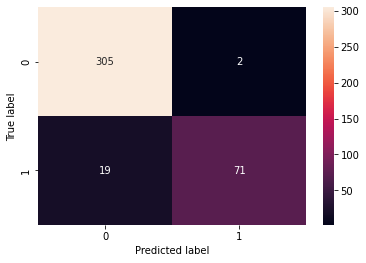

In [36]:
actual = predictions.select('label').toPandas()
predicted = predictions.select('prediction').toPandas()

print('Accuracy score of predicted data :',accuracy_score(actual, predicted))

# precision score
print('Precision Score of predicted data :',precision_score(actual, predicted))

# recall score
print('Recall Score of predicted data :',recall_score(actual, predicted))

# F1 score
print('F1 Score of predicted data :',f1_score(actual, predicted))

cf_matrix = confusion_matrix(actual, predicted)
sn.heatmap(cf_matrix, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Proposed Ways

In [37]:
predictions_modified_1 = make_predictions_based_on_modifications(df, pipelineModel, model, solution=1)
predictions_modified_2 = make_predictions_based_on_modifications(df, pipelineModel, model, solution=2)

+----------+-----+--------------------+
|prediction|count|            solution|
+----------+-----+--------------------+
|  No Churn| 1685|Online Security S...|
|     Churn|  342|Online Security S...|
+----------+-----+--------------------+

+----------+-----+--------------------+
|prediction|count|            solution|
+----------+-----+--------------------+
|  No Churn| 1615|Monthly Charge Di...|
|     Churn|  412|Monthly Charge Di...|
+----------+-----+--------------------+



In [38]:
predictions_modified = predictions_modified_1.union(predictions_modified_2)
predictions_modified.show()

+----------+-----+--------------------+
|prediction|count|            solution|
+----------+-----+--------------------+
|  No Churn| 1685|Online Security S...|
|     Churn|  342|Online Security S...|
|  No Churn| 1615|Monthly Charge Di...|
|     Churn|  412|Monthly Charge Di...|
+----------+-----+--------------------+



# Insertion to DB

In [39]:
driver = 'com.mysql.jdbc.Driver'
insert_to_mysql(feature_importance_df, predictions_modified, HOST, DB_NAME, DB_USER, DB_PASS, driver)

True